# For 'Learning Word Vectors for Sentiment Analysis' by:
### Maas, A., Daly, R., Pham, P., Huang, D., Ng, A., and Potts, C.,
##    Cf. http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf

# Imports

In [635]:
#!/usr/bin/env python

from __future__ import print_function

import platform
import sys
import os
import locale
import glob
from time import time

import multiprocessing

import warnings
warnings.simplefilter(action='ignore')

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import codecs
import tarfile
from smart_open import smart_open

import requests
import bs4
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen

from random import sample, shuffle

from itertools import groupby
from more_itertools import unique_everseen
from operator import itemgetter
from collections import namedtuple, defaultdict, OrderedDict, Counter

import numpy as np
import pandas as pd

import re
import regex
import string
import textwrap
from textwrap import fill

#import pycontractions
#from pycontractions import Contractions
import autocorrect
from autocorrect import spell

import textacy
from textacy.preprocess import remove_punct

import spacy
from spacy.tokenizer import Tokenizer

import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import afinn
from afinn import Afinn

import pattern
from pattern.en import sentiment #, mood, modality

import gensim
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from gensim.models.doc2vec import TaggedDocument
#must pip install testfixtures
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import statsmodels
import statsmodels.api as sm

import imblearn
from imblearn.over_sampling import SMOTE, ADASYN

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense#, Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import seaborn as sns

import plotly
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#connects JS to notebook so plots work inline
init_notebook_mode(connected=True)

import cufflinks as cf
#allow offline use of cufflinks
cf.go_offline()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jkras\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Environment and Library Information

In [637]:
#environment and package versions
print('\n')
print("_"*70)
print('The environment and package versions used in this script are:')
print('\n')

print(platform.platform())
print('Python', sys.version)
print('OS', os.name)
print('Beautiful Soup', bs4.__version__)
print('Urllib', urllib.request.__version__) 
print('Regex', re.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Textacy', textacy.__version__)
print('SpaCy', spacy.__version__)
print('NLTK', nltk.__version__)
print('Pattern', pattern.__version__)
print('Gensim', gensim.__version__)
print('StatsModels', statsmodels.__version__)
print('ImbLearn', imblearn.__version__)
print('Sklearn', sklearn.__version__)
print('Keras', keras.__version__)
print('Matplotlib', matplotlib.__version__)
print('Seaborn', sns.__version__)
print('Plotly', plotly.__version__)
print('Cufflinks', cf.__version__)

print('\n')
print("~"*70)
print('\n')



______________________________________________________________________
The environment and package versions used in this script are:


Windows-10-10.0.17134-SP0
Python 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
OS nt
Beautiful Soup 4.6.0
Urllib 3.6
Regex 2.2.1
Numpy 1.15.4
Pandas 0.22.0
Textacy 0.6.2
SpaCy 2.0.12
NLTK 3.2.2
Pattern 3.6
Gensim 3.6.0
StatsModels 0.8.0
ImbLearn 0.3.3
Sklearn 0.19.1
Keras 2.1.5
Matplotlib 2.2.2
Seaborn 0.7.1
Plotly 2.2.2
Cufflinks 0.12.1


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




# Helper Functions

In [4]:
# Convert text to lower-case and strip punctuation/symbols from words
def normalize_text(text):
    norm_text = text.lower()
    # Replace breaks with spaces
    norm_text = norm_text.replace('<br />', ' ')
    # Pad punctuation with spaces on both sides
    norm_text = re.sub(r"([\.\",\(\)!\?;:])", " \\1 ", norm_text)
    return norm_text

In [5]:
def logistic_predictor_from_data(train_targets, train_regressors):
    """Fit a statsmodel logistic predictor on supplied data"""
    logit = sm.Logit(train_targets, train_regressors)
    predictor = logit.fit(disp=0)
    # print(predictor.summary())
    return predictor

In [6]:
def error_rate_for_model(test_model, train_set, test_set, 
                         reinfer_train=False, reinfer_test=False, 
                         infer_steps=None, infer_alpha=None, infer_subsample=0.2):
    """Report error rate on test_doc sentiments, using supplied model and train_docs"""

    train_targets = [doc.sentiment for doc in train_set]
    if reinfer_train:
        train_regressors = [test_model.infer_vector(doc.words, steps=infer_steps, alpha=infer_alpha) for doc in train_set]
    else:
        train_regressors = [test_model.docvecs[doc.tags[0]] for doc in train_set]
    train_regressors = sm.add_constant(train_regressors)
    predictor = logistic_predictor_from_data(train_targets, train_regressors)

    test_data = test_set
    if reinfer_test:
        if infer_subsample < 1.0:
            test_data = sample(test_data, int(infer_subsample * len(test_data)))
        test_regressors = [test_model.infer_vector(doc.words, steps=infer_steps, alpha=infer_alpha) for doc in test_data]
    else:
        test_regressors = [test_model.docvecs[doc.tags[0]] for doc in test_set]
    test_regressors = sm.add_constant(test_regressors)
    
    # Predict & evaluate
    test_predictions = predictor.predict(test_regressors)
    corrects = sum(np.rint(test_predictions) == [doc.sentiment for doc in test_data])
    errors = len(test_predictions) - corrects
    error_rate = float(errors) / len(test_predictions)
    return (error_rate, errors, len(test_predictions), predictor)

In [226]:
def get_movie_reviews(soup_broth, n_reviews_per_movie=1):
    
    print('Retrieving all baseline URLs... \n')

    base_urls = [ ("https://www.imdb.com" + tag.attrs['href'], tag.text.replace('\n',' ') ) 
                            for tag in soup_broth.findAll('a', attrs={'href': re.compile("^/title/.*_tt")}) ]
    
    print('Retrieved all second-level URLs... \n')

    level_2_urls = []
    for url, title in base_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        update_url = [("https://www.imdb.com" + tag.attrs['href']) 
                            for tag in soup.findAll('a', attrs={'href': re.compile("^/title/.*tt_urv")})]
        level_2_urls.append((update_url[0], title))
        
    print('Retrieved all third-level URLs... \n')

    level_3_urls = []
    for url, title in level_2_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        update_url = [("https://www.imdb.com" + tag.attrs['href'])
                          for tag in soup.findAll('a', attrs={'href': re.compile("^/review/.*tt_urv")})[:(n_reviews_per_movie*2)]]
        update_url = list(unique_everseen(update_url))
        for i in update_url:
            level_3_urls.append((i, title))
        
    print('Retrieved all fourth-level URLs... \n')

    level_4_urls = []
    for url, title in level_3_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        update_url = [("https://www.imdb.com" + soup.find('a', href=re.compile("^/review/.*rw_urv"))['href'])]
        level_4_urls.append((update_url[0], title))
        
    print('Retrieved all fifth-level URLs... \n')

    level_5_text = []
    for url, title in level_4_urls:
        soup = BeautifulSoup(urlopen(url).read(), 'html.parser')
        review_text = [(soup.find('div', {'class' : re.compile("^text")}).text)]
        
        span = soup.find('span', attrs={'rating-other-user-rating'})
        if span != None:
            stars = str(span.find('span').text).strip()
        else:
            stars = 5
        
        level_5_text.append((review_text[0], title, stars))
        
    print('All reviews retrieved! \n')

    return level_5_text

In [9]:
def clean_component(review, stop_words, tokenizer, puncts):
    """Text Cleaner: Tokenize, Remove Stopwords, Punctuation, Lemmatize, Spell Correct, Lowercase"""
    
    #rev_contract_exp = list(contract_model.expand_texts([review], precise=True))
    
    doc_tok = tokenizer(review)

    doc_lems = [tok.lemma_ for tok in doc_tok 
                    if (tok.text not in stop_words
                        and tok.text not in puncts
                        and tok.pos_ != "PUNCT" and tok.pos_ != "SYM")]
    
    lem_list = [re.search(r'\(?([0-9A-Za-z-]+)\)?', tok).group(1) 
                    if '-' in tok 
                    else spell(remove_punct(tok)) 
                        for tok in doc_lems]

    doc2vec_input = [t.lower() for tok in lem_list 
                         for t in tok.split() 
                             if t.lower() not in stop_words]
    
    return doc2vec_input

In [392]:
def get_tagged_documents(input_review_texts, stop_words, tokenizer, puncts, sentence_labeler):
    print('Creating Tagged Documents... \n')
    
    all_content = []
    j=0
    for rev, ttl, strz in input_review_texts:
        print('Cleaning review #{} \n'.format(j+1))
        clean_rev = clean_component(rev, stop_words, tokenizer, puncts)
        print('The number of stars for this review is: {}'.format(strz))
        all_content.append(sentence_labeler(clean_rev, [tuple([ttl, float(strz)])]))
        j += 1

    print('Total Number of Movie Review Document Vectors: ', j)
    
    return all_content

In [518]:
def pattern_sentiment(review, threshold=0.1, verbose=False):
    analysis = sentiment(review)
    sentiment_score = round(analysis[0], 3)
    sentiment_subjectivity = round(analysis[1], 3)

    final_sentiment = 'positive' if sentiment_score >= threshold else 'negative'
    sent_binary = 1 if sentiment_score >= threshold else 0
    
    if verbose:
        #detailed sentiment statistics
        sentiment_frame = pd.DataFrame([[final_sentiment, sentiment_score, sentiment_subjectivity]],
        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'],
                                      ['Predicted Sentiment','Polarity Score','Subjectivity Score']],
                                      labels=[[0,0,0],[0,1,2]]))
        print(sentiment_frame, '\n')
        
        assessment = analysis.assessments
        assessment_frame = pd.DataFrame(assessment, 
                                        columns=pd.MultiIndex(levels=[['DETAILED ASSESSMENT STATS:'],
                                                                ['Key Terms', 'Polarity Score', 'Subjectivity Score','Type']],
                                                                labels=[[0,0,0,0],[0,1,2,3]]))
        #print(assessment_frame)

    return final_sentiment, sentiment_frame, assessment_frame, sent_binary

In [656]:
def afinn_sentiment(review, threshold, verbose=False):
    
    afn = Afinn(emoticons=True)
    sent_binary = (np.array(afn.score(review))>threshold).astype(int)
        
    final_sentiment = 'positive' if sent_binary == 1 else 'negative'
    
    if verbose:
        sentiment_frame = pd.DataFrame([[final_sentiment, sent_binary]],
                                       columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'],
                                            ['Predicted Sentiment', 'Binary Score']],
                                            labels=[[0,0],[0,1]]))
    
        print(sentiment_frame, '\n')
    
    return sent_binary

In [650]:
def sentiwordnet_sentiment(review, verbose=False):

    text_tokens = nltk.word_tokenize(review)
    tagged_text = nltk.pos_tag(text_tokens)
    pos_score = neg_score = token_count = obj_score = 0
    
    # get wordnet synsets based on POS tags
    # get sentiment scores if synsets are found
    for word, tag in tagged_text:
        ss_set = None
        
        if 'NN' in tag and swn.senti_synsets(word, 'n'):
            ss_set = list(swn.senti_synsets(word, 'n'))
        elif 'VB' in tag and swn.senti_synsets(word, 'v'):
            ss_set = list(swn.senti_synsets(word, 'v'))
        elif 'JJ' in tag and swn.senti_synsets(word, 'a'):
            ss_set = list(swn.senti_synsets(word, 'a'))
        elif 'RB' in tag and swn.senti_synsets(word, 'r'):
            ss_set = list(swn.senti_synsets(word, 'r'))
        
        # if senti-synset is found
        if ss_set:
            # add scores for all found synsets
            for s in ss_set:
                pos_score += s.pos_score()
                neg_score += s.neg_score()
                obj_score += s.obj_score()
            token_count += 1
        
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 'positive' if norm_final_score >= 0 else 'negative'
    
    sent_binary = 1 if final_sentiment == 'positive' else 0
    
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score, norm_pos_score, norm_neg_score, norm_final_score]],
                                       columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'],
                                                        ['Predicted Sentiment','Objectivity','Positive', 'Negative','Overall']],
                                                        labels=[[0,0,0,0,0],[0,1,2,3,4]]))
        
        print(sentiment_frame, '\n')
    
    return sent_binary

In [651]:
def vader_sentiment(review, threshold=0.1, verbose=False):
    
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    #get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold else 'negative'
    
    sent_binary = 1 if final_sentiment == 'positive' else 0 
    
    if verbose:
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive, negative, neutral]],
                                       columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'],
                                            ['Predicted Sentiment', 'Polarity Score', 'Positive', 'Negative', 'Neutral']],
                                            labels=[[0,0,0,0,0],[0,1,2,3,4]]))
    
    print(sentiment_frame, '\n')
    
    return sent_binary

In [520]:
def pretty_print(input_text):
    
    for r in input_text:
        pieces = [str(ele) for ele in r]
        for p in pieces:
            write_up = fill(p)
            print(write_up, '\n')
    
    return None

# Download and Clean Large Movie Review Dataset
## Cf. https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [11]:
%%time

dirname = 'aclImdb'
filename = 'aclImdb_v1.tar.gz'
locale.setlocale(locale.LC_ALL, 'C')
all_lines = []

if sys.version > '3':
    control_chars = [chr(0x85)]
else:
    control_chars = [unichr(0x85)]

if not os.path.isfile('./aclImdb/alldata-id.txt'):
    if not os.path.isdir(dirname):
        if not os.path.isfile(filename):
            # Download IMDB archive
            print("Downloading IMDB archive...")
            url = u'http://ai.stanford.edu/~amaas/data/sentiment/' + filename
            r = requests.get(url)
            with smart_open(filename, 'wb') as f:
                f.write(r.content)
        # if error here, try `tar xfz aclImdb_v1.tar.gz` outside notebook, then re-run this cell
        tar = tarfile.open(filename, mode='r')
        tar.extractall()
        tar.close()
    else:
        print("IMDB archive directory already available without download.")
        
    # Collect & normalize test/train data
    print("Cleaning up dataset...")
    folders = ['train/pos', 'train/neg', 'test/pos', 'test/neg', 'train/unsup']
    for fol in folders:
        temp = u''
        newline = "\n".encode("utf-8")
        output = fol.replace('/', '-') + '.txt'
        # Is there a better pattern to use?
        txt_files = glob.glob(os.path.join(dirname, fol, '*.txt'))
        print(" %s: %i files" % (fol, len(txt_files)))
        with smart_open(os.path.join(dirname, output), "wb") as n:
            for i, txt in enumerate(txt_files):
                with smart_open(txt, "rb") as t:
                    one_text = t.read().decode("utf-8")
                    for c in control_chars:
                        one_text = one_text.replace(c, ' ')
                    one_text = normalize_text(one_text)
                    all_lines.append(one_text)
                    n.write(one_text.encode("utf-8"))
                    n.write(newline)
        
    # Save to disk for instant re-use on any future runs
    with smart_open(os.path.join(dirname, 'alldata-id.txt'), 'wb') as f:
        for idx, line in enumerate(all_lines):
            num_line = u"_*{0} {1}\n".format(idx, line)
            f.write(num_line.encode("utf-8"))
            
assert os.path.isfile("aclImdb/alldata-id.txt"), "alldata-id.txt unavailable"
print("Success, alldata-id.txt is available for next steps.")

Success, alldata-id.txt is available for next steps.
Wall time: 1.97 ms


# Train/Test Split Large Movie Review Dataset
##   Cf. http://ai.stanford.edu/~amaas/data/sentiment/

In [12]:
%%time

# this data object class suffices as a `TaggedDocument` (with `words` and `tags`) 
# plus adds other state helpful for our later evaluation/reporting
SentimentDocument = namedtuple('SentimentDocument', 'words tags split sentiment')

alldocs = []
with smart_open('./aclImdb/alldata-id.txt', 'rb', encoding='utf-8') as alldata:
    for line_no, line in enumerate(alldata):
        tokens = gensim.utils.to_unicode(line).split()
        words = tokens[1:]
        tags = [line_no] # 'tags = [tokens[0]]' would also work at extra memory cost
        split = ['train', 'test', 'extra', 'extra'][line_no//25000]  # 25k train, 25k test, 25k extra
        sentiment = [1.0, 0.0, 1.0, 0.0, None, None, None, None][line_no//12500] # [12.5K pos, 12.5K neg]*2 then unknown
        alldocs.append(SentimentDocument(words, tags, split, sentiment))

train_docs = [doc for doc in alldocs if doc.split == 'train']
test_docs = [doc for doc in alldocs if doc.split == 'test']

print('%d docs: %d train-sentiment, %d test-sentiment' % (len(alldocs), len(train_docs), len(test_docs)))

100000 docs: 25000 train-sentiment, 25000 test-sentiment
Wall time: 3.18 s


# Shuffle Reviews for Better Learning

In [13]:
doc_list = alldocs[:]  
shuffle(doc_list)

# Train Distributed Bag-of-Words (DBOW) Model
## Cf. https://arxiv.org/pdf/1607.05368.pdf

In [14]:
%%time

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

simple_models = [
    # PV-DBOW plain
    Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, 
            epochs=20, workers=cores),
    # PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
    #Doc2Vec(dm=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, sample=0, 
    #        epochs=20, workers=cores, alpha=0.05, comment='alpha=0.05'),
    # PV-DM w/ concatenation - big, slow, experimental mode
    # window=5 (both sides) approximates paper's apparent 10-word total window size
    #Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, sample=0, 
    #        epochs=20, workers=cores),
]

for model in simple_models:
    model.build_vocab(alldocs)
    print("%s vocabulary scanned & state initialized" % model)

models_by_name = OrderedDict((str(model), model) for model in simple_models)

Doc2Vec(dbow,d100,n5,mc2,t8) vocabulary scanned & state initialized
Wall time: 7.87 s


In [15]:
#models_by_name['dbow+dmm'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[1]])
#models_by_name['dbow+dmc'] = ConcatenatedDoc2Vec([simple_models[0], simple_models[2]])

In [16]:
#models_by_name.items()

In [17]:
for model in simple_models: 
    print("Training %s" % model)
    %time model.train(doc_list, total_examples=len(doc_list), epochs=model.epochs)

Training Doc2Vec(dbow,d100,n5,mc2,t8)
Wall time: 3min 46s


# Compute Error Rate of DBOW Model

In [18]:
#to selectively print only best errors achieved
error_rates = defaultdict(lambda: 1.0)

In [19]:
for model in simple_models:
    print("\nEvaluating %s" % model)
    %time err_rate, err_count, test_count, predictor = error_rate_for_model(model, train_docs, test_docs)
    error_rates[str(model)] = err_rate
    print("\n%f %s\n" % (err_rate, model))


Evaluating Doc2Vec(dbow,d100,n5,mc2,t8)
Wall time: 789 ms

0.102800 Doc2Vec(dbow,d100,n5,mc2,t8)



In [20]:
#for model in [models_by_name['dbow+dmm'], models_by_name['dbow+dmc']]: 
#    print("\nEvaluating %s" % model)
#    %time err_rate, err_count, test_count, predictor = error_rate_for_model(model, train_docs, test_docs)
#    error_rates[str(model)] = err_rate
#    print("\n%f %s\n" % (err_rate, model))

In [21]:
# Compare error rates achieved, best-to-worst
print("Err_rate Model")
for rate, name in sorted((rate, name) for name, rate in error_rates.items()):
    print("%f %s" % (rate, name))

Err_rate Model
0.102800 Doc2Vec(dbow,d100,n5,mc2,t8)


# Retrieve Arrays of Regressors and Targets

In [22]:
#dbow = simple_models[0]
#dmm = simple_models[1]
#dmc = simple_models[2]

dbow = simple_models[0]

In [23]:
train_targets = [doc.sentiment for doc in train_docs]
test_targets = [doc.sentiment for doc in test_docs]

In [24]:
dbow_train_regressors = [dbow.docvecs[doc.tags[0]] for doc in train_docs]
dbow_test_regressors = [dbow.docvecs[doc.tags[0]] for doc in test_docs]

# Train and Evaluate Logistic Regression Classifier

In [25]:
clf = LogisticRegression()
clf.fit(dbow_train_regressors, train_targets)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [629]:
print('Logistic Classifier performance on the training set is: {}'.format(clf.score(dbow_train_regressors, train_targets)))
print('Logistic Classifier performance on the test set is: {}'.format(clf.score(dbow_test_regressors, test_targets)))

Logistic Classifier performance on the training set is: 0.89596
Logistic Classifier performance on the test set is: 0.89732


In [604]:
#predict method to generate predictions from Logistic model and test data
logistic_pred = clf.predict(dbow_test_regressors)

threshold=0.5

[[11231  1269]
 [ 1298 11202]]


             precision    recall  f1-score   support

        0.0       0.90      0.90      0.90     12500
        1.0       0.90      0.90      0.90     12500

avg / total       0.90      0.90      0.90     25000

Correct classification rate: 0.89732




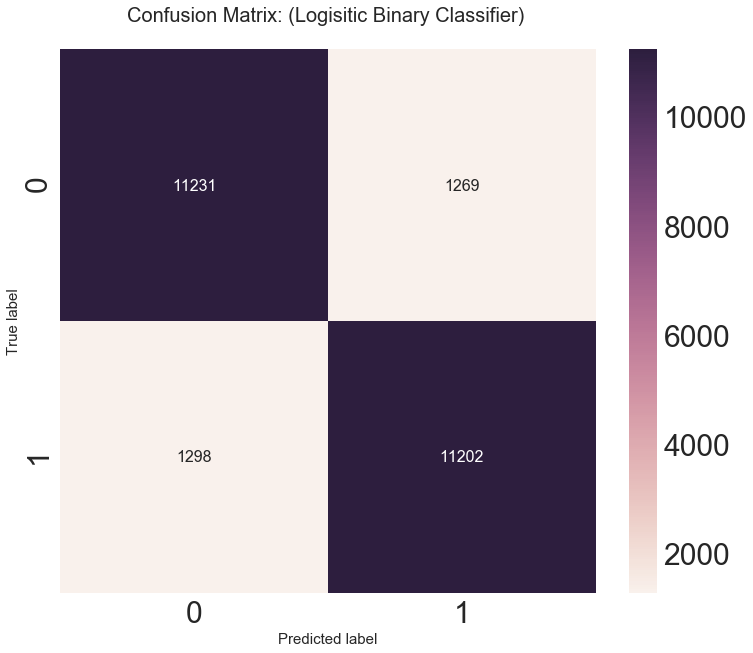

In [605]:
print(confusion_matrix(np.array(test_targets), (logistic_pred>threshold).astype(int)))
print('\n')
print(classification_report(np.array(test_targets), (logistic_pred>threshold).astype(int)))

#classification accuracy score
logisitic_accuracy = accuracy_score(np.array(test_targets), (logistic_pred>threshold).astype(int))
print("Correct classification rate:", logisitic_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(test_targets), (logistic_pred>threshold).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (Logisitic Binary Classifier) \n', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

# Shape Regressor Arrays for Input to Dense Neural Network (DNN) Classifier

In [29]:
dbow.docvecs.vectors_docs.shape

(100000, 100)

In [30]:
np.stack(dbow_train_regressors, axis=0).shape

(25000, 100)

In [31]:
np.stack(dbow_test_regressors, axis=0).shape

(25000, 100)

In [32]:
dbow_train_input = np.stack(dbow_train_regressors, axis=0)

In [567]:
dbow_test_input = np.stack(dbow_test_regressors, axis=0)

# Train and Evaluate DBOW Dense Neural Network Classifier

In [569]:
K.clear_session()

np.random.seed(222)
model_d2v_01 = Sequential()
model_d2v_01.add(Dense(64, activation='relu', input_dim=100))
model_d2v_01.add(Dense(32, activation='relu'))
model_d2v_01.add(Dense(16, activation='relu'))
model_d2v_01.add(Dense(8, activation='relu'))
model_d2v_01.add(Dense(1, activation='sigmoid'))
model_d2v_01.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_01.fit(dbow_train_input, train_targets, validation_split=0.20,
                 #validation_data=(dbow_test_regressors, test_targets),
                 epochs=10, batch_size=32, verbose=2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 2s - loss: 0.3067 - acc: 0.8700 - val_loss: 0.4698 - val_acc: 0.8048
Epoch 2/10
 - 1s - loss: 0.2574 - acc: 0.8952 - val_loss: 0.4252 - val_acc: 0.8268
Epoch 3/10
 - 1s - loss: 0.2445 - acc: 0.9027 - val_loss: 0.2926 - val_acc: 0.8844
Epoch 4/10
 - 1s - loss: 0.2318 - acc: 0.9058 - val_loss: 0.3064 - val_acc: 0.8790
Epoch 5/10
 - 1s - loss: 0.2209 - acc: 0.9132 - val_loss: 0.3990 - val_acc: 0.8384
Epoch 6/10
 - 1s - loss: 0.2098 - acc: 0.9166 - val_loss: 0.2948 - val_acc: 0.8862
Epoch 7/10
 - 1s - loss: 0.2002 - acc: 0.9226 - val_loss: 0.4498 - val_acc: 0.8234
Epoch 8/10
 - 1s - loss: 0.1905 - acc: 0.9258 - val_loss: 0.3764 - val_acc: 0.8538
Epoch 9/10
 - 1s - loss: 0.1815 - acc: 0.9297 - val_loss: 0.3095 - val_acc: 0.8814
Epoch 10/10
 - 1s - loss: 0.1735 - acc: 0.9330 - val_loss: 0.3272 - val_acc: 0.8678


In [35]:
#NB: saving model can throw segmentation fault!
#model_d2v_01.save('./imdb_dbow_25000revs_0.2_split.hdf5', include_optimizer=True)

In [36]:
#NB: early stopping model checkpoint can throw segmentation fault!

#%%time

#filepath="./d2v_dbow_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
#filepath="d2v_dbow_best_weights.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#early_stop = EarlyStopping(monitor='val_acc', patience=10, mode='max') 
#callbacks_list = [checkpoint, early_stop]

#np.random.seed(222)
#d2v_dbow_es = Sequential()
#d2v_dbow_es.add(Dense(32, activation='relu', input_dim=100))
#d2v_dbow_es.add(Dense(8, activation='relu'))
#d2v_dbow_es.add(Dense(4, activation='relu'))
#d2v_dbow_es.add(Dense(1, activation='sigmoid'))
#d2v_dbow_es.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

#d2v_dbow_es.fit(dbow_train_input, train_targets, validation_split=0.25, 
#                    epochs=50, batch_size=32, verbose=2, callbacks=callbacks_list)

In [570]:
model_d2v_01.evaluate(x=dbow_test_input, y=test_targets)

25000/25000 [==============================] - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - 1s 23us/step


[0.30340484449863436, 0.88132]

In [571]:
#predict method to generate predictions from DNN model and test data
pred = model_d2v_01.predict(dbow_test_input)

threshold=0.5

[[10750  1750]
 [ 1217 11283]]


             precision    recall  f1-score   support

        0.0       0.90      0.86      0.88     12500
        1.0       0.87      0.90      0.88     12500

avg / total       0.88      0.88      0.88     25000

Correct classification rate: 0.88132




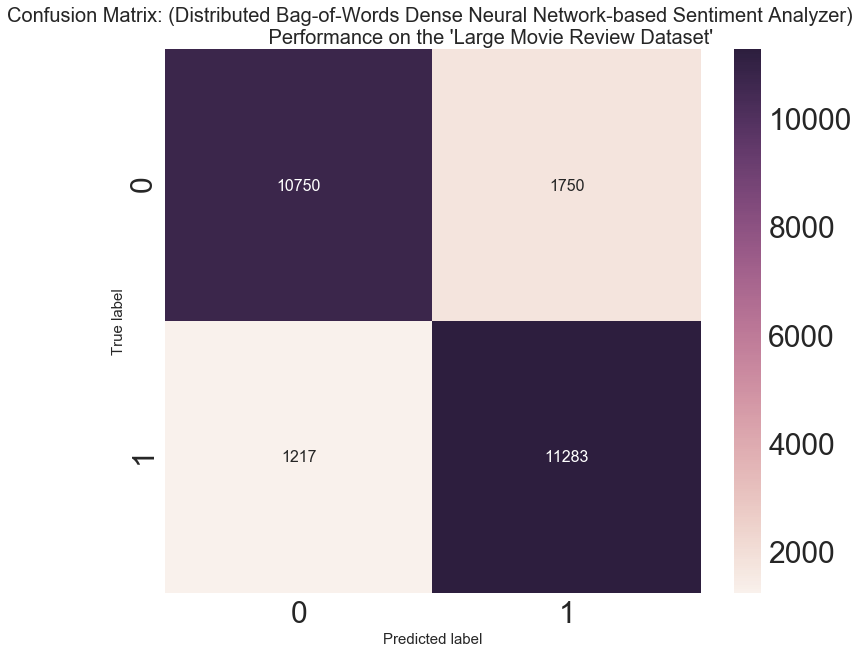

In [576]:
print(confusion_matrix(np.array(test_targets), (pred>threshold).astype(int)))
print('\n')
print(classification_report(np.array(test_targets), (pred>threshold).astype(int)))

#classification accuracy score
large_movie_rev_dataset_accuracy = accuracy_score(np.array(test_targets), (pred>threshold).astype(int))
print("Correct classification rate:", large_movie_rev_dataset_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(test_targets), (pred>threshold).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (Distributed Bag-of-Words Dense Neural Network-based Sentiment Analyzer) \n \
                    Performance on the \'Large Movie Review Dataset\'', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

# Train on all Data to Apply Model to External Test Set

In [46]:
traintest_docs = [doc for doc in alldocs if doc.split in ['train','test']]

In [47]:
len(traintest_docs)

50000

In [582]:
dbow_all_regressors = [dbow.docvecs[doc.tags[0]] for doc in traintest_docs]
dbow_all_targets = [doc.sentiment for doc in traintest_docs]

dbow_all_input = np.stack(dbow_all_regressors, axis=0)

In [583]:
K.clear_session()

np.random.seed(999)
model_d2v_all = Sequential()
model_d2v_all.add(Dense(64, activation='relu', input_dim=100))
model_d2v_all.add(Dense(32, activation='relu'))
model_d2v_all.add(Dense(16, activation='relu'))
model_d2v_all.add(Dense(8, activation='relu'))
model_d2v_all.add(Dense(1, activation='sigmoid'))
model_d2v_all.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_all.fit(dbow_all_input, dbow_all_targets, validation_split=0.20,
                 #validation_data=(dbow_test_regressors, test_targets),
                 epochs=10, batch_size=32, verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.2806 - acc: 0.8830 - val_loss: 0.4448 - val_acc: 0.8032
Epoch 2/10
 - 1s - loss: 0.2427 - acc: 0.9027 - val_loss: 0.3232 - val_acc: 0.8715
Epoch 3/10
 - 1s - loss: 0.2320 - acc: 0.9078 - val_loss: 0.3504 - val_acc: 0.8527
Epoch 4/10
 - 1s - loss: 0.2240 - acc: 0.9120 - val_loss: 0.3079 - val_acc: 0.8674
Epoch 5/10
 - 1s - loss: 0.2152 - acc: 0.9154 - val_loss: 0.3333 - val_acc: 0.8603
Epoch 6/10
 - 1s - loss: 0.2103 - acc: 0.9174 - val_loss: 0.5252 - val_acc: 0.7972
Epoch 7/10
 - 1s - loss: 0.2039 - acc: 0.9198 - val_loss: 0.3526 - val_acc: 0.8554
Epoch 8/10
 - 1s - loss: 0.1985 - acc: 0.9236 - val_loss: 0.3600 - val_acc: 0.8502
Epoch 9/10
 - 1s - loss: 0.1931 - acc: 0.9262 - val_loss: 0.3597 - val_acc: 0.8494
Epoch 10/10
 - 1s - loss: 0.1890 - acc: 0.9289 - val_loss: 0.3057 - val_acc: 0.8804


# Crawl IMDB for 1000 reviews of the 100 Best and Worst Horror Movies

In [228]:
nlp = spacy.load('en')

#cont = Contractions('../GoogleNews-vectors-negative300.bin.gz')
#cont.load_models()

punctuations = string.punctuation

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument

tokenizer = Tokenizer(nlp.vocab)

#stopwords = spacy.lang.en.STOP_WORDS
#spacy.lang.en.STOP_WORDS.add("e.g.")
#nlp.vocab['the'].is_stop
#nlp.Defaults.stop_words |= {"(a)", "(b)", "(c)", "etc", "etc.", "etc.)", "w/e", "(e.g.", "no?", "s", 
#                           "film", "movie","0","1","2","3","4","5","6","7","8","9","10","e","f","k","n","q",
#                            "de","oh","ones","miike","http","imdb", "horror", "little", 
#                            "come", "way", "know", "michael", "lot", "thing", "films", "later", "actually", "find", 
#                            "big", "long", "away", "filmthe", "www", "com", "x", "aja", "agritos", "lon", "therebravo", 
#                            "gou", "b", "particularly", "probably", "sure", "greenskeeper", "try", 
#                            "half", "intothe", "especially", "exactly", "20", "ukr", "thatll", "darn", "certainly", "simply", }

#stopwords = list(nlp.Defaults.stop_words)

stopwords = list(["(a)", "(b)", "(c)", "etc", "etc.", "etc.)", "w/e", "(e.g.", "no?", "s", 
                 "0","1","2","3","4","5","6","7","8","9","10","e","f","k","n","q",
                 "de","oh","miike","http","imdb","michael","filmthe","www","com","x", 
                 "aja","agritos","lon","therebravo","gou","b","intothe","20", "ukr","thatll"])

In [229]:
#open the base URL webpage
html_page = urlopen("https://www.imdb.com/list/ls059633855/")

#instantiate beautiful soup object of the html page
soup = BeautifulSoup(html_page, 'lxml')

review_text_first_5 = get_movie_reviews(soup, n_reviews_per_movie=5)

Retrieving all baseline URLs... 

Retrieved all second-level URLs... 

Retrieved all third-level URLs... 

Retrieved all fourth-level URLs... 

Retrieved all fifth-level URLs... 

All reviews retrieved! 



In [240]:
all_good_movie_reviews_500 = get_tagged_documents(review_text_first_5, stopwords, tokenizer, punctuations, LabeledSentence1)

Creating Tagged Documents... 

Cleaning review #1 

The number of stars for this review is: 5
Cleaning review #2 

The number of stars for this review is: 9
Cleaning review #3 

The number of stars for this review is: 8
Cleaning review #4 

The number of stars for this review is: 10
Cleaning review #5 

The number of stars for this review is: 9
Cleaning review #6 

The number of stars for this review is: 9
Cleaning review #7 

The number of stars for this review is: 8
Cleaning review #8 

The number of stars for this review is: 5
Cleaning review #9 

The number of stars for this review is: 8
Cleaning review #10 

The number of stars for this review is: 10
Cleaning review #11 

The number of stars for this review is: 10
Cleaning review #12 

The number of stars for this review is: 10
Cleaning review #13 

The number of stars for this review is: 5
Cleaning review #14 

The number of stars for this review is: 10
Cleaning review #15 

The number of stars for this review is: 10
Cleaning rev

In [241]:
#open the base URL webpage
html_page_bad = urlopen("https://www.imdb.com/list/ls061324742/")

#instantiate beautiful soup object of the html page
soup_bad = BeautifulSoup(html_page_bad, 'lxml')

review_text_first_5_bad = get_movie_reviews(soup_bad, n_reviews_per_movie=5)

Retrieving all baseline URLs... 

Retrieved all second-level URLs... 

Retrieved all third-level URLs... 

Retrieved all fourth-level URLs... 

Retrieved all fifth-level URLs... 

All reviews retrieved! 



In [244]:
all_bad_movie_reviews_500 = get_tagged_documents(review_text_first_5_bad, stopwords, tokenizer, punctuations, LabeledSentence1)

Creating Tagged Documents... 

Cleaning review #1 

The number of stars for this review is: 7
Cleaning review #2 

The number of stars for this review is: 5
Cleaning review #3 

The number of stars for this review is: 9
Cleaning review #4 

The number of stars for this review is: 9
Cleaning review #5 

The number of stars for this review is: 9
Cleaning review #6 

The number of stars for this review is: 5
Cleaning review #7 

The number of stars for this review is: 5
Cleaning review #8 

The number of stars for this review is: 7
Cleaning review #9 

The number of stars for this review is: 3
Cleaning review #10 

The number of stars for this review is: 5
Cleaning review #11 

The number of stars for this review is: 5
Cleaning review #12 

The number of stars for this review is: 6
Cleaning review #13 

The number of stars for this review is: 5
Cleaning review #14 

The number of stars for this review is: 5
Cleaning review #15 

The number of stars for this review is: 3
Cleaning review #1

# Combine all Reviews

In [245]:
all_reviews = all_good_movie_reviews_500 + all_bad_movie_reviews_500

In [348]:
all_reviews_text = []
all_reviews_ttl = []
all_reviews_strz = []
for i,j in all_reviews:
    if j[0][1] == 5:
        continue
    else:
        all_reviews_text.append(i)
        all_reviews_ttl.append(j[0][0])
        all_reviews_strz.append(j[0][1])

#reg_ex = regex.compile('[^a-zA-Z]')

#dictionary = corpora.Dictionary(all_reviews_text)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
#filtered_dict = dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
#corpus = [dictionary.doc2bow(text) for text in all_reviews_text]

all_reviews_joined = [' '.join(w) for w in all_reviews_text]

print(len(all_reviews_text), len(all_reviews_ttl), len(all_reviews_strz), len(all_reviews_joined))

808 808 808 808


# Use the Number of Stars as an Approximation to 'Ground Truth' Labels

In [270]:
all_strz_binary = []
for strz in all_reviews_strz:
    strz = 1 if strz > 5.0 else 0
    all_strz_binary.append(strz)

In [584]:
true_targets = all_strz_binary

# Use DBOW Model to Infer Vector space of Web-Scraped Reviews

In [606]:
rev_regressors = [dbow.infer_vector(rev, epochs=200) for rev in all_reviews_text]

# Shape Regressor Arrays for Input to trained DNN Classifier

In [608]:
nn_rev_input = np.stack(rev_regressors, axis=0)

In [609]:
nn_rev_input.shape

(808, 100)

# Evaluate trained DNN Classifier on Web-Scraped Reviews

In [610]:
model_d2v_all.evaluate(x=nn_rev_input, y=true_targets)

808/808 [==============================] - ETA: 0s - 0s 23us/step


[0.6962011533208413, 0.7524752475247525]

In [611]:
#predict method to generate predictions from DNN model and test data
pred_rev = model_d2v_all.predict(nn_rev_input)

In [612]:
threshold=0.5

[[111   4]
 [196 497]]


             precision    recall  f1-score   support

          0       0.36      0.97      0.53       115
          1       0.99      0.72      0.83       693

avg / total       0.90      0.75      0.79       808

Correct classification rate: 0.7524752475247525




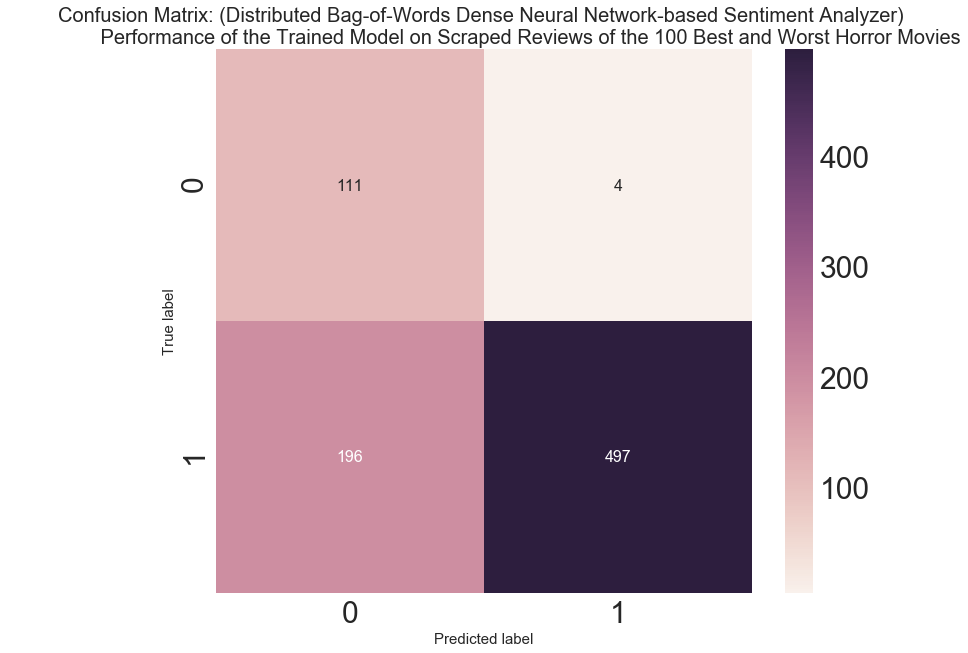

In [613]:
print(confusion_matrix(np.array(true_targets), (pred_rev>threshold).astype(int)))
print('\n')
print(classification_report(np.array(true_targets), (pred_rev>threshold).astype(int)))

#classification accuracy score
dbow_dnn_horror_rev_accuracy = accuracy_score(np.array(true_targets), (pred_rev>threshold).astype(int))
print("Correct classification rate:", dbow_dnn_horror_rev_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(true_targets), (pred_rev>threshold).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (Distributed Bag-of-Words Dense Neural Network-based Sentiment Analyzer) \n \
                Performance of the Trained Model on Scraped Reviews of the 100 Best and Worst Horror Movies', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

# Investigate Misclassified Reviews

In [461]:
true_targets_arr = np.array(true_targets)
true_targets_arr.shape

(808,)

In [462]:
pred_rev_arr = pred_rev.reshape(len(pred_rev))
pred_rev_arr = (pred_rev_arr>threshold).astype(int)
pred_rev_arr.shape

(808,)

In [463]:
misclass_indices_pos = np.where((true_targets_arr != pred_rev_arr) & (pred_rev_arr == 0))
misclass_indices_pos

(array([  3,  12,  13,  16,  18,  24,  29,  35,  39,  43,  51,  55,  62,
         68,  73,  75,  83,  90,  99, 100, 111, 112, 122, 131, 132, 134,
        135, 140, 151, 152, 170, 182, 188, 197, 212, 213, 216, 226, 227,
        236, 237, 245, 247, 249, 251, 255, 258, 259, 260, 280, 281, 290,
        306, 313, 315, 318, 321, 322, 323, 324, 325, 333, 339, 349, 356,
        361, 363, 371, 377, 383, 384, 395, 401, 402, 404, 410, 423, 438,
        439, 442, 443, 446, 454, 456, 458, 459, 465, 466, 469, 471, 473,
        479, 489, 490, 491, 494, 496, 497, 498, 504, 506, 508, 509, 511,
        516, 521, 523, 524, 526, 551, 564, 566, 568, 569, 570, 571, 573,
        578, 586, 587, 588, 590, 592, 594, 595, 596, 599, 602, 608, 611,
        619, 620, 621, 623, 625, 642, 646, 648, 655, 666, 667, 672, 673,
        674, 688, 689, 690, 691, 693, 694, 695, 706, 709, 711, 714, 715,
        719, 728, 729, 730, 732, 734, 736, 741, 743, 758, 764, 774, 777,
        782, 788, 790, 791, 800, 801, 805, 807], dt

In [464]:
misclass_indices_neg = np.where((true_targets_arr != pred_rev_arr) & (pred_rev_arr == 1))
misclass_indices_neg

(array([221, 550, 576, 639, 797], dtype=int64),)

In [465]:
misclass_revs_neg = [(all_reviews_joined[i], all_reviews_ttl[i], all_reviews_strz[i]) for i in misclass_indices_neg[0]]

misclass_revs_pos = [(all_reviews_joined[i], all_reviews_ttl[i], all_reviews_strz[i]) for i in misclass_indices_pos[0]]

In [466]:
print('The false positives produced by the DBOW Sentiment Classifier were: \n\n')
pretty_print(misclass_revs_neg)

The false positives produced by the DBOW Sentiment Classifier were: 


great idea that unfortunately fall short of what i expected both lead
character be make to purposefully fall short in their ability to
outsmart one another by simply be mediocre at be the killer and the
obvious survivor so youre not so much glue in anticipation to the
outcome but much so find yourself wait for the inevitable the film
lose its ability to scare you a the killer reveal himself too early
and when he doe his face lessen what be already a non threaten mask i
didnt see any twist or turn and nothing make me feel surprise or
shocked which be a shame a i feel the core of this movie be a
fantastic idea 

Hush 

4.0 

a lot have be write and say about alien of the unauthorized follow up
of alien i watch it year ago and just can remember the fall head
attack by a alien so i watch it again but my only concern be to catch
the uncut version english language a lot have be say about the run
time took i have see versi

In [467]:
print('The false negatives produced by the DBOW Sentiment Classifier were: \n\n')
pretty_print(misclass_revs_pos)

The false negatives produced by the DBOW Sentiment Classifier were: 


i want to start this review with say that i be not completely against
jump scares they play integral part of horror movies but when a movie
mostly rely on them and be not support with great story i be always
leave displeased what make the wailing so special be that there be
almost no jump scare at all in this film instead we the viewers be
take through a story rich with mystery great character and their
struggles dark atmosphere with good design and amazingly craft horror
scene that make your blood run cold also in addition the movie carry a
great subtext leave for the viewer to question find evidence and
interpret it you can feel that the director take some time and do some
research to give us a much real horror experience a possible one may
find the wailing a bite bore because the film be a slow burner and not
construct a much of modern horror films or may find the film too long
running time th 36min but if you be

# Visualize Distributions of Targets and Predictions

In [468]:
x0 = pred_rev.flatten()
x1 = true_targets

trace1 = go.Histogram(
    x=x0,
    opacity=0.4,
    name='Predicted Class <br> Probabilities',
    xbins=dict(
        start=-0.1,
        end=1.1,
        size=0.05
    ),
)
trace2 = go.Histogram(
    x=x1,
    opacity=0.4,
    name='True Classes',
    xbins=dict(
        start=-0.1,
        end=1.1,
        size=0.05
    ),
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay',
                    title='Distributed Bag-of-Words Dense Neural Network Classifier Results',
                    xaxis=dict(
                        title='Class Probabilities'
                    ),
                    yaxis=dict(
                        title='Number of Reviews'
                    ),)
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='overlaid histogram')

# Apply SMOTE and ADASYN Oversampling to Negative Reviews
## Cf. https://arxiv.org/pdf/1106.1813.pdf
##       http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.309.942&rep=rep1&type=pdf

In [469]:
# ## Applying Over-Sampling to Under-represented Classes

# ### Using the Synthetic Minority Over-Sampling Technique (SMOTE)
# ### On SMOTE over-sampling, Cf. https://arxiv.org/pdf/1106.1813.pdf
# #### Cf. also http://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf and
# #### https://pdfs.semanticscholar.org/f11b/4f012d704f757599bd7881c278dcc6816c7c.pdf

# ### Using Adaptive Synthetic Sampling (ADASYN)
# ### On ADASYN, Cf. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.309.942&rep=rep1&type=pdf

# Evaluate DBOW DNN Classifier Performance after Oversampling

SMOTE upsampled counts of classes: 

[(0, 693), (1, 693)]


ADASYN upsampled counts of classes: 

[(0, 710), (1, 693)]


Evaluting SMOTE and ADASYN upsampled models...
1403/1403 [==============================] - ETA: 0s - 0s 23us/step


[[684   9]
 [196 497]]


             precision    recall  f1-score   support

          0       0.78      0.99      0.87       693
          1       0.98      0.72      0.83       693

avg / total       0.88      0.85      0.85      1386

Correct classification rate: (SMOTE)  0.8520923520923521


[[698  12]
 [196 497]]


             precision    recall  f1-score   support

          0       0.78      0.98      0.87       710
          1       0.98      0.72      0.83       693

avg / total       0.88      0.85      0.85      1403

Correct classification rate: (ADASYN)  0.8517462580185318




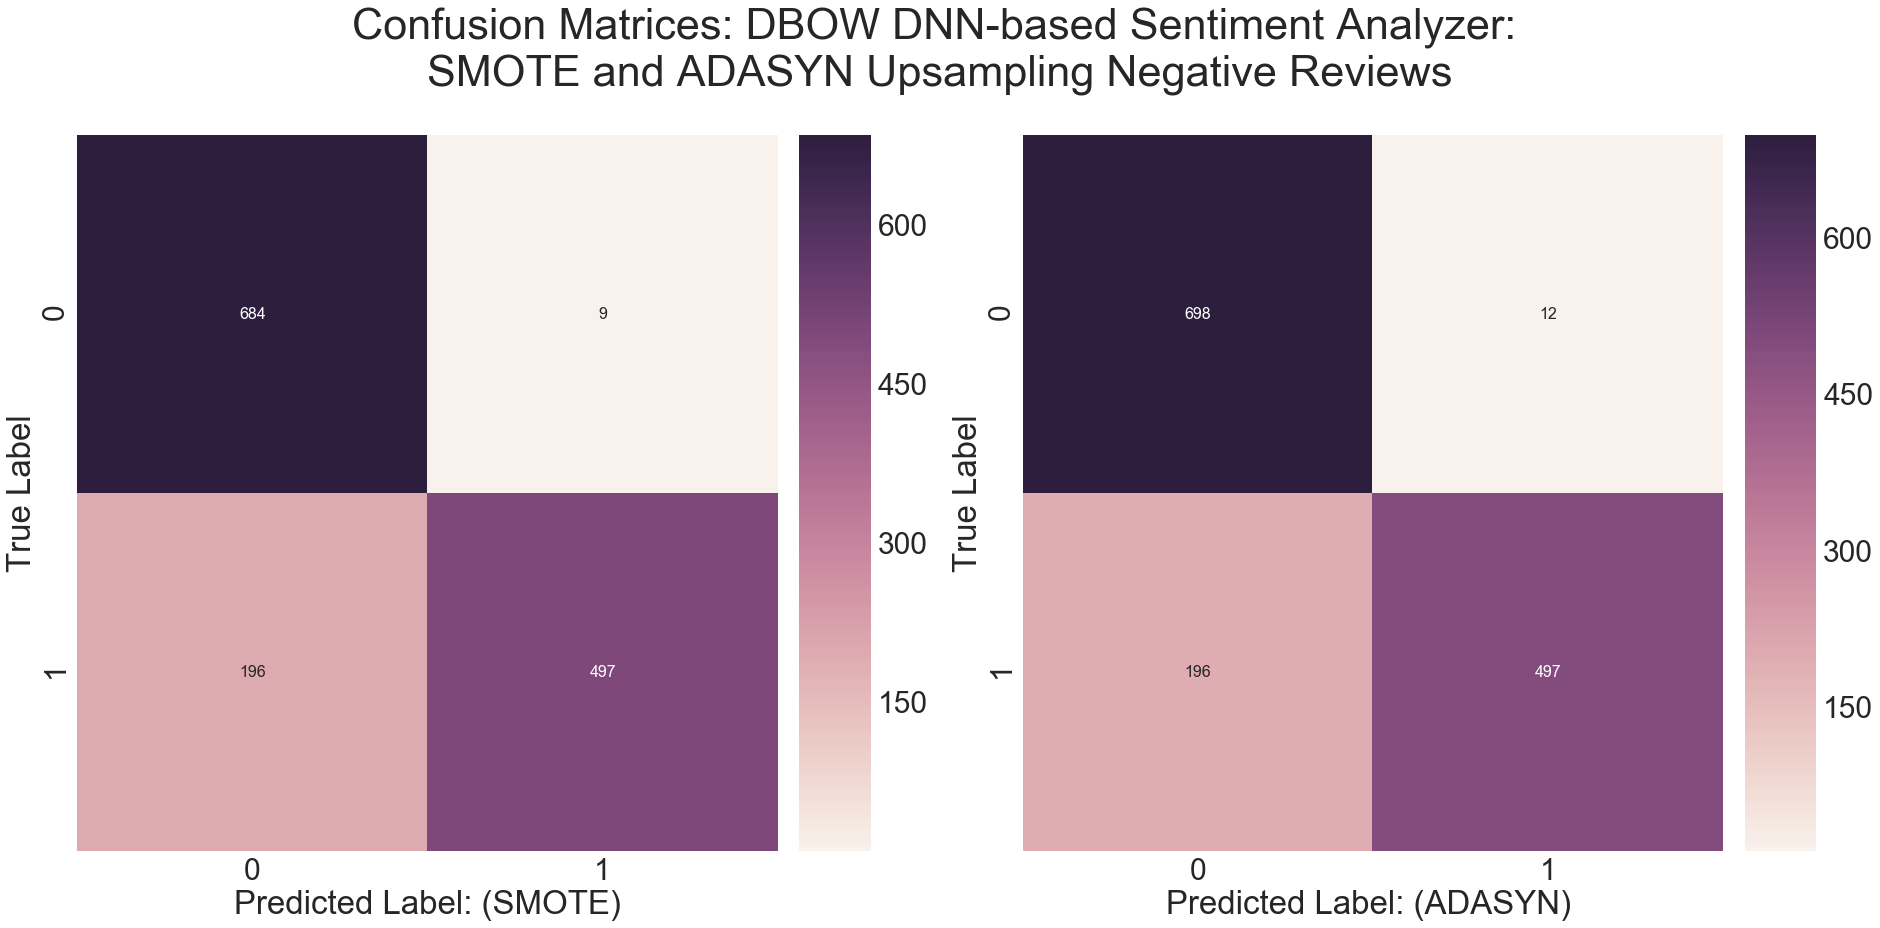

<Figure size 576x396 with 0 Axes>

In [614]:
X_SMOTE, y_SMOTE = SMOTE().fit_sample(nn_rev_input, true_targets)

print('SMOTE upsampled counts of classes: \n')
print(sorted(Counter(y_SMOTE).items()))
print('\n')

X_ADASYN, y_ADASYN = ADASYN().fit_sample(nn_rev_input, true_targets)

print('ADASYN upsampled counts of classes: \n')
print(sorted(Counter(y_ADASYN).items()))
print('\n')

print('Evaluting SMOTE and ADASYN upsampled models...')
model_d2v_all.evaluate(X_SMOTE, y_SMOTE)
model_d2v_all.evaluate(X_ADASYN , y_ADASYN)

#predict method to generate predictions from DNN model and test data
y_SMOTE_pred = model_d2v_all.predict(X_SMOTE)

#predict method to generate predictions from DNN model and test data
y_ADASYN_pred = model_d2v_all.predict(X_ADASYN)

threshold=0.5

print('\n')
print(confusion_matrix(np.array(y_SMOTE), (y_SMOTE_pred>threshold).astype(int)))
print('\n')
print(classification_report(np.array(y_SMOTE), (y_SMOTE_pred>threshold).astype(int)))

dbow_dnn_smote_accuracy = accuracy_score(np.array(y_SMOTE), (np.array(y_SMOTE_pred)>threshold).astype(int))
print("Correct classification rate: (SMOTE) ", dbow_dnn_smote_accuracy)
print('\n')

print(confusion_matrix(np.array(y_ADASYN), (y_ADASYN_pred>threshold).astype(int)))
print('\n')
print(classification_report(np.array(y_ADASYN), (y_ADASYN_pred>threshold).astype(int)))

dbow_dnn_adasyn_accuracy = accuracy_score(np.array(y_ADASYN), (np.array(y_ADASYN_pred)>threshold).astype(int))
print("Correct classification rate: (ADASYN) ", dbow_dnn_adasyn_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)

model_types = 'DBOW DNN-based Sentiment Analyzer: \n SMOTE and ADASYN Upsampling Negative Reviews'

conf_matrix_SMOTE = confusion_matrix(np.array(y_SMOTE), (np.array(y_SMOTE_pred)>threshold).astype(int))
conf_matrix_ADASYN = confusion_matrix(np.array(y_ADASYN), (np.array(y_ADASYN_pred)>threshold).astype(int))

fig = plt.figure(constrained_layout=True, figsize=(26,13))

gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, -1])

sns.heatmap(conf_matrix_SMOTE, annot=True, fmt="d", annot_kws={"size": 16}, ax=ax1)
ax1.set_xlabel('Predicted Label: (SMOTE)')
ax1.set_ylabel('True Label')

sns.heatmap(conf_matrix_ADASYN, annot=True, fmt="d", annot_kws={"size": 16}, ax=ax2)
ax2.set_xlabel('Predicted Label: (ADASYN) ')
ax2.set_ylabel('True Label')

fig.suptitle('Confusion Matrices: {} \n'.format(model_types))

plt.show()
plt.tight_layout()

# Apply Lexicon-based Sentiment Analyzers to Scraped Reviews

## Implement Pattern Sentiment Analyzer
### Cf. https://www.clips.uantwerpen.be/pages/pattern-en#sentiment

In [443]:
#sent_df.iloc[:, sent_df.columns.get_level_values(1)=='Predicted Sentiment']

In [485]:
Rev_SentimentDocument = namedtuple('SentimentDocument', 'words ttl tags pattern_sent_score')

i=0
pattern_output = []
for rev, ttl in zip(all_reviews_joined, all_reviews_ttl):
    final_sent, sent_df, assess_df, sent_binary = pattern_sentiment(rev, threshold=0.1, verbose=True)
    words = rev
    tags = i
    pattern_sent_score = float(sent_binary)
    pattern_output.append(Rev_SentimentDocument(words, ttl, tags, pattern_sent_score))
    print(fill(words[:250]), '\n')
    print('Movie title: {} \n'.format(ttl), '\n')
    i += 1

     SENTIMENT STATS:                                  
  Predicted Sentiment Polarity Score Subjectivity Score
0            positive          0.204              0.482 

spoilers have see a lot of films review a lot of film but this
extraordinary two and a half hour technically-perfect humanistic
horror film from one of the fine writer directors in the business
auteur of i saw the devil be something of a cipher the c 

Movie title: The Wailing 
 

     SENTIMENT STATS:                                  
  Predicted Sentiment Polarity Score Subjectivity Score
0            negative          0.037              0.527 

the wailing open with a quote from the bible it be easy to forget this
fact while watch much of the film but at a certain point it become
clear the purpose that quote served it be almost like a warning if you
be a religious person this film will scar 

Movie title: The Wailing 
 

     SENTIMENT STATS:                                  
  Predicted Sentiment Polarity Score Sub

In [521]:
pattern_preds = [doc.pattern_sent_score for doc in pattern_output]

## Evaluate Pattern Sentiment Analyzer

[[ 99  16]
 [335 358]]


             precision    recall  f1-score   support

          0       0.23      0.86      0.36       115
          1       0.96      0.52      0.67       693

avg / total       0.85      0.57      0.63       808

Correct classification rate: 0.5655940594059405




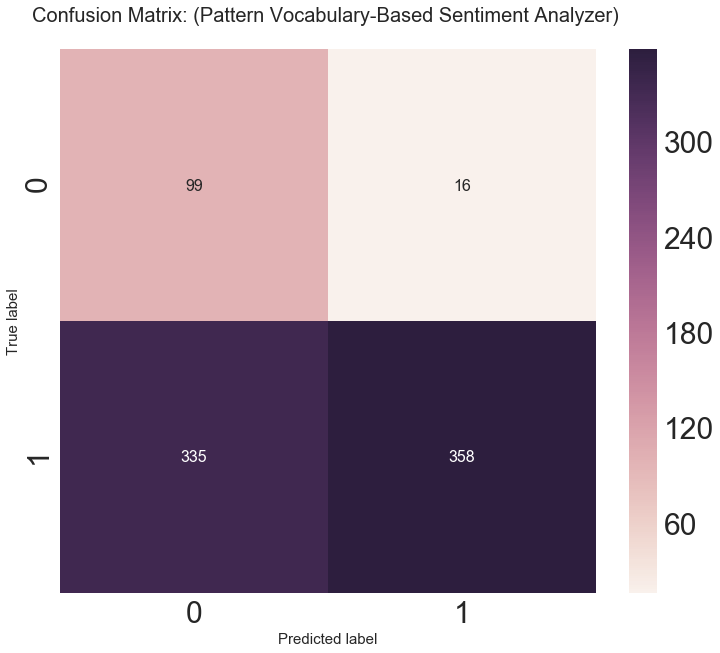

In [594]:
print(confusion_matrix(np.array(true_targets), (np.array(pattern_preds)>threshold).astype(int)))
print('\n')
print(classification_report(np.array(true_targets), (np.array(pattern_preds)>threshold).astype(int)))

#classification accuracy score
pattern_accuracy = accuracy_score(np.array(true_targets), (np.array(pattern_preds)>threshold).astype(int))
print("Correct classification rate:", pattern_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(true_targets), (np.array(pattern_preds)>threshold).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (Pattern Vocabulary-Based Sentiment Analyzer) \n', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

## Implement AFINN Sentiment Analyzer
### Cf. https://github.com/fnielsen/afinn

In [648]:
afn = Afinn(emoticons=True)
threshold = 0.0

In [647]:
Rev_SentimentDocument = namedtuple('SentimentDocument', 'words ttl tags afinn_sent_score')

i=0
afinn_output = []
for rev, ttl in zip(all_reviews_joined, all_reviews_ttl):
    sent_binary = afinn_sentiment(rev, threshold, verbose=True)
    words = rev
    tags = i
    afinn_sent_score = float(sent_binary)
    afinn_output.append(Rev_SentimentDocument(words, ttl, tags, afinn_sent_score))
    print(fill(words[:250]), '\n')
    print('Movie title: {} \n'.format(ttl), '\n')
    i += 1

     SENTIMENT STATS:             
  Predicted Sentiment Binary Score
0            positive            1 

spoilers have see a lot of films review a lot of film but this
extraordinary two and a half hour technically-perfect humanistic
horror film from one of the fine writer directors in the business
auteur of i saw the devil be something of a cipher the c 

Movie title: The Wailing 
 

     SENTIMENT STATS:             
  Predicted Sentiment Binary Score
0            positive            1 

the wailing open with a quote from the bible it be easy to forget this
fact while watch much of the film but at a certain point it become
clear the purpose that quote served it be almost like a warning if you
be a religious person this film will scar 

Movie title: The Wailing 
 

     SENTIMENT STATS:             
  Predicted Sentiment Binary Score
0            positive            1 

this movie be a hell of a ride about of minute into the movie i stop
to look at how much time be leave and be actua

In [652]:
afinn_preds_raw = [afn.score(rev) for rev in all_reviews_joined]
afinn_preds = (np.array(afinn_preds_raw)>threshold).astype(int)

## Evaluate AFINN Sentiment Analyzer

[[ 89  26]
 [216 477]]


             precision    recall  f1-score   support

          0       0.29      0.77      0.42       115
          1       0.95      0.69      0.80       693

avg / total       0.85      0.70      0.74       808

Correct classification rate: 0.7004950495049505




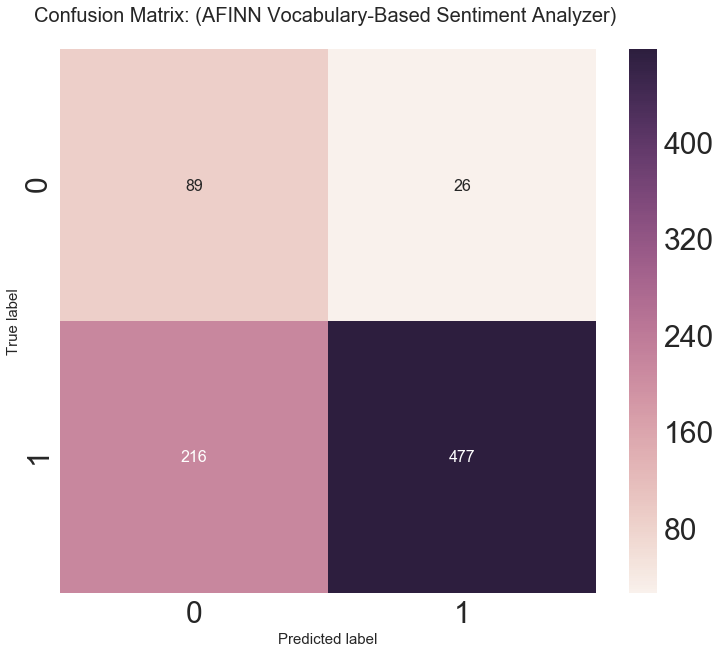

In [595]:
print(confusion_matrix(np.array(true_targets), (np.array(afinn_preds)>threshold).astype(int)))
print('\n')
print(classification_report(np.array(true_targets), (np.array(afinn_preds)>threshold).astype(int)))

#classification accuracy score
afinn_accuracy = accuracy_score(np.array(true_targets), (np.array(afinn_preds)>threshold).astype(int))
print("Correct classification rate:", afinn_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(true_targets), (np.array(afinn_preds)>threshold).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (AFINN Vocabulary-Based Sentiment Analyzer) \n', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

## Implement SentiWordNet Sentiment Analyzer

In [516]:
Rev_SentimentDocument = namedtuple('SentimentDocument', 'words ttl tags wn_sent_score')

i=0
sentiwordnet_output = []
for rev, ttl in zip(all_reviews_joined, all_reviews_ttl):
    sent_binary = sentiwordnet_sentiment(rev, verbose=True)
    words = rev
    tags = i
    wn_sent_score = float(sent_binary)
    sentiwordnet_output.append(Rev_SentimentDocument(words, ttl, tags, wn_sent_score))
    print(fill(words[:250]), '\n')
    print('Movie title: {} \n'.format(ttl), '\n')
    i += 1

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        6.74     0.49     0.25    0.24


spoilers have see a lot of films review a lot of film but this
extraordinary two and a half hour technically-perfect humanistic
horror film from one of the fine writer directors in the business
auteur of i saw the devil be something of a cipher the c 

Movie title: The Wailing 
 

     SENTIMENT STATS:                                      
  Predicted Sentiment Objectivity Positive Negative Overall
0            positive        6.83     0.59     0.34    0.25


the wailing open with a quote from the bible it be easy to forget this
fact while watch much of the film but at a certain point it become
clear the purpose that quote served it be almost like a warning if you
be a religious person this film will scar 

Movie title: The Wailing 
 

     SENTIMENT STATS:                                      
  Predicted 

In [522]:
sentiwordnet_preds = [doc.wn_sent_score for doc in sentiwordnet_output]

## Evaluate SentiWordNet Sentiment Analyzer

[[ 38  77]
 [ 94 599]]


             precision    recall  f1-score   support

          0       0.29      0.33      0.31       115
          1       0.89      0.86      0.88       693

avg / total       0.80      0.79      0.79       808

Correct classification rate: 0.7883663366336634




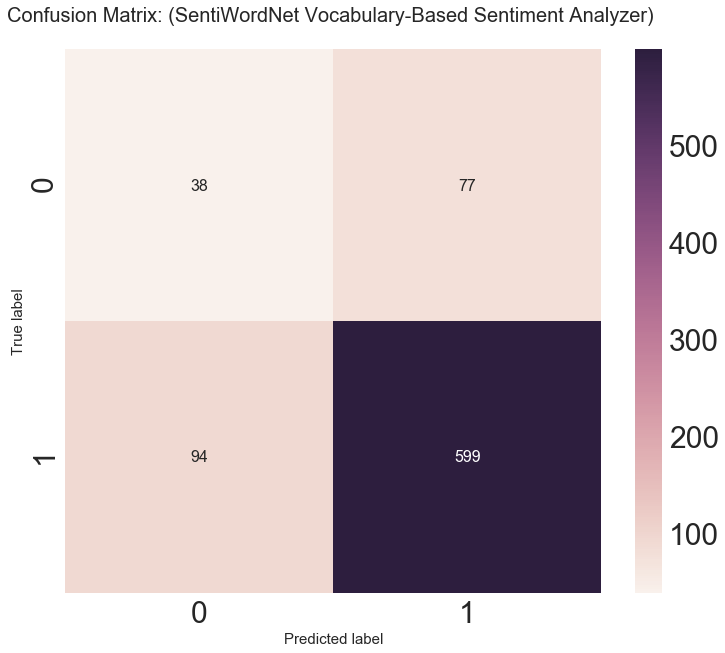

In [596]:
print(confusion_matrix(np.array(true_targets), np.array(sentiwordnet_preds).astype(int)))
print('\n')
print(classification_report(np.array(true_targets), np.array(sentiwordnet_preds).astype(int)))

#classification accuracy score
sentiwordnet_accuracy = accuracy_score(np.array(true_targets), np.array(sentiwordnet_preds).astype(int))
print("Correct classification rate:", sentiwordnet_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(true_targets), np.array(sentiwordnet_preds).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (SentiWordNet Vocabulary-Based Sentiment Analyzer) \n', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

## Implement VADER Sentiment Analyzer

In [534]:
Rev_SentimentDocument = namedtuple('SentimentDocument', 'words ttl tags vader_sent_score')

i=0
vader_output = []
for rev, ttl in zip(all_reviews_joined, all_reviews_ttl):
    sent_binary = vader_sentiment(rev, verbose=True)
    words = rev
    tags = i
    vader_sent_score = float(sent_binary)
    vader_output.append(Rev_SentimentDocument(words, ttl, tags, vader_sent_score))
    print(fill(words[:250]), '\n')
    print('Movie title: {} \n'.format(ttl), '\n')
    i += 1

     SENTIMENT STATS:                                         
  Predicted Sentiment Polarity Score Positive Negative Neutral
0            positive           0.36    10.0%     9.0%   81.0%


spoilers have see a lot of films review a lot of film but this
extraordinary two and a half hour technically-perfect humanistic
horror film from one of the fine writer directors in the business
auteur of i saw the devil be something of a cipher the c 

Movie title: The Wailing 
 

     SENTIMENT STATS:                                                     
  Predicted Sentiment Polarity Score Positive             Negative Neutral
0            positive            0.2    15.0%  14.000000000000002%   71.0%


the wailing open with a quote from the bible it be easy to forget this
fact while watch much of the film but at a certain point it become
clear the purpose that quote served it be almost like a warning if you
be a religious person this film will scar 

Movie title: The Wailing 
 

     SENTIMENT STA

In [535]:
vader_preds = [doc.vader_sent_score for doc in vader_output]

## Evaluate VADER Sentiment Analyzer

[[ 86  29]
 [265 428]]


             precision    recall  f1-score   support

          0       0.25      0.75      0.37       115
          1       0.94      0.62      0.74       693

avg / total       0.84      0.64      0.69       808

Correct classification rate: 0.6361386138613861




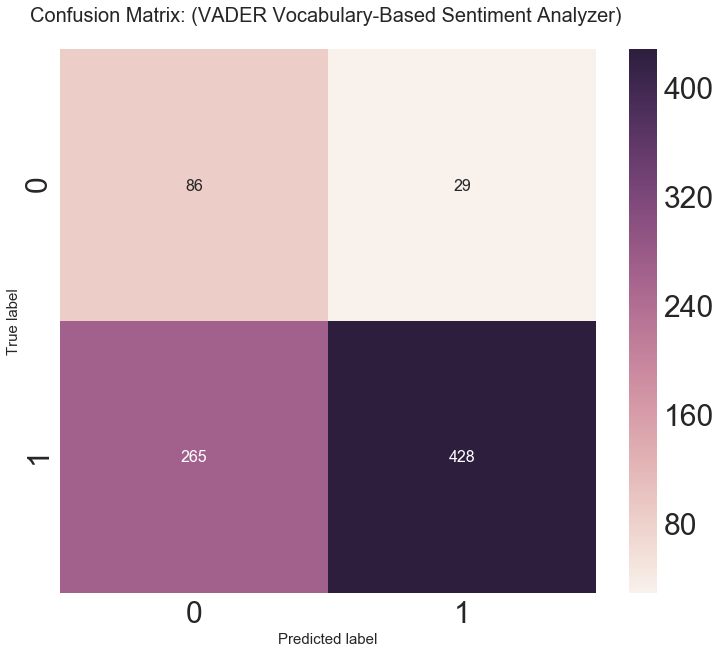

In [597]:
print(confusion_matrix(np.array(true_targets), np.array(vader_preds).astype(int)))
print('\n')
print(classification_report(np.array(true_targets), np.array(vader_preds).astype(int)))

#classification accuracy score
vader_accuracy = accuracy_score(np.array(true_targets), np.array(vader_preds).astype(int))
print("Correct classification rate:", vader_accuracy)
print('\n')

#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)
conf_matrix = confusion_matrix(np.array(true_targets), np.array(vader_preds).astype(int))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 16});
plt.title('Confusion Matrix: (VADER Vocabulary-Based Sentiment Analyzer) \n', fontsize=20)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.show()

# Performance Evaluation across Lexicon-based Sentiment Analyzers

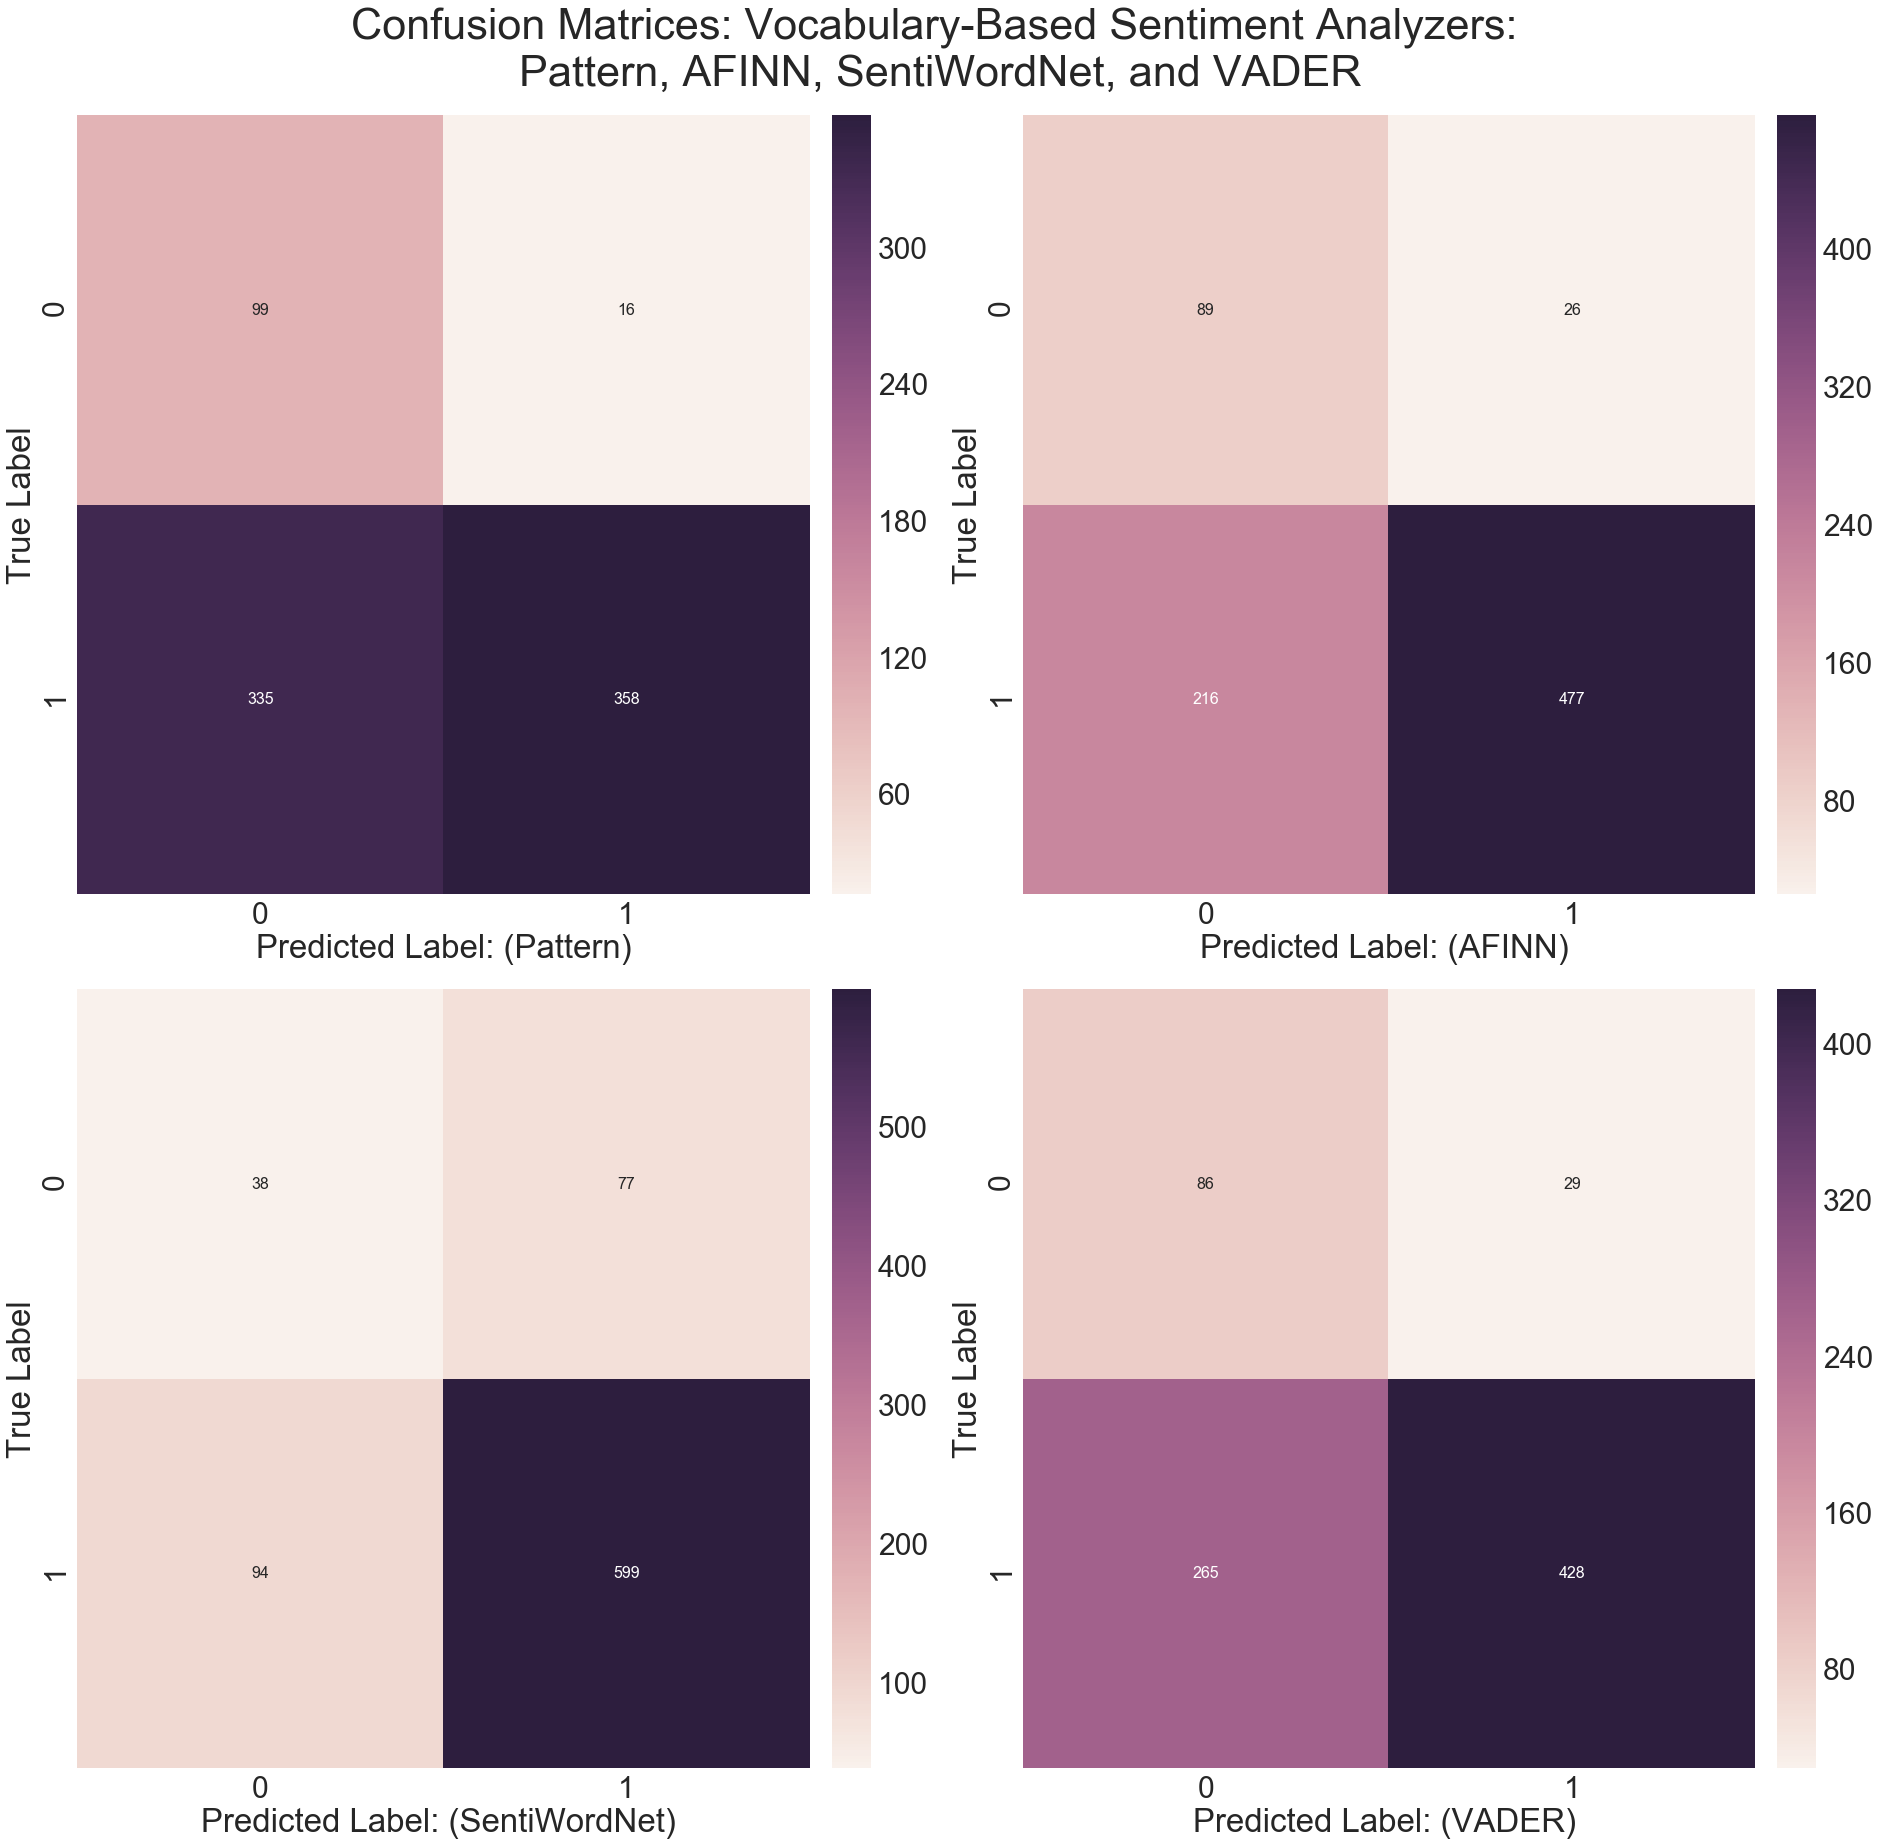

<Figure size 576x396 with 0 Axes>

In [598]:
#Visualize confusion matrix as a heatmap
sns.set(font_scale=3)

model_types = 'Vocabulary-Based Sentiment Analyzers: \n Pattern, AFINN, SentiWordNet, and VADER'


threshold = 0.1
conf_matrix_pattern = confusion_matrix(np.array(true_targets), (np.array(pattern_preds)>threshold).astype(int))

threshold = 0.0
conf_matrix_afinn = confusion_matrix(np.array(true_targets), (np.array(afinn_preds)>threshold).astype(int))

conf_matrix_sentiwordnet = confusion_matrix(np.array(true_targets), np.array(sentiwordnet_preds).astype(int))

conf_matrix_vader = confusion_matrix(np.array(true_targets), np.array(vader_preds).astype(int))


fig = plt.figure(constrained_layout=True, figsize=(26,26))

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, -1])
ax3 = fig.add_subplot(gs[-1, 0])
ax4 = fig.add_subplot(gs[-1, -1])

sns.heatmap(conf_matrix_pattern, annot=True, fmt="d", annot_kws={"size": 16}, ax=ax1)
ax1.set_xlabel('Predicted Label: (Pattern)')
ax1.set_ylabel('True Label')

sns.heatmap(conf_matrix_afinn, annot=True, fmt="d", annot_kws={"size": 16}, ax=ax2)
ax2.set_xlabel('Predicted Label: (AFINN) ')
ax2.set_ylabel('True Label')

sns.heatmap(conf_matrix_sentiwordnet, annot=True, fmt="d", annot_kws={"size": 16}, ax=ax3)
ax3.set_xlabel('Predicted Label: (SentiWordNet) ')
ax3.set_ylabel('True Label')

sns.heatmap(conf_matrix_vader, annot=True, fmt="d", annot_kws={"size": 16}, ax=ax4)
ax4.set_xlabel('Predicted Label: (VADER) ')
ax4.set_ylabel('True Label')


fig.suptitle('Confusion Matrices: {} \n'.format(model_types))

plt.show()
plt.tight_layout()

# Final Performance Comparison with DBOW DNN Sentiment Classifiers

In [634]:
accuracy_scores = dict([('DBOW_DNN_SMOTE',dbow_dnn_smote_accuracy), 
                       ('DBOW_DNN_ADASYN',dbow_dnn_adasyn_accuracy),
                       ('PATTERN',pattern_accuracy),
                       ('AFINN',afinn_accuracy),
                       ('SentiWordNet',sentiwordnet_accuracy),
                       ('VADER',vader_accuracy)])

accuracy_scores

{'AFINN': 0.7004950495049505,
 'DBOW_DNN_ADASYN': 0.8517462580185318,
 'DBOW_DNN_SMOTE': 0.8520923520923521,
 'PATTERN': 0.5655940594059405,
 'SentiWordNet': 0.7883663366336634,
 'VADER': 0.6361386138613861}

In [616]:
sorted_accuracy_scores = [(k, accuracy_scores[k]) for k in sorted(accuracy_scores, key=accuracy_scores.get, reverse=True)]

In [617]:
print('The Sorted Accuracy Scores of the Implemented Classifiers are: \n')
for k,v in sorted_accuracy_scores:
    print(k + ':', v, '\n')

The Sorted Accuracy Scores of the Implemented Classifiers are: 

DBOW_DNN_SMOTE: 0.8520923520923521 

DBOW_DNN_ADASYN: 0.8517462580185318 

SentiWordNet: 0.7883663366336634 

AFINN: 0.7004950495049505 

VADER: 0.6361386138613861 

PATTERN: 0.5655940594059405 



In [659]:
print('The best performing sentiment classifier is {}!'.format(sorted_accuracy_scores[0]))

The best performing sentiment classifier is ('DBOW_DNN_SMOTE', 0.8520923520923521)!
